# Grid cell model 

Code Structure is the following:

- Define the grid cell coordinates (n^2 x 2) (x and y)
- Define the 1 dim distance between 2 set of coordinates of neurons
- Define the a new grid with the preference direction
- Define the recurrent connectivity profile using the distance calculated before
- Defineand solve the differential equation defining the dynamics of the system for a number of time steps
- Plotting the result

In [3]:
# grid cell model 
#phase offset detector:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Create a grid, so coordinates for the 2D neural sheet. with 2 matrices y_:[[0 0 ... 0],[1 1 ... 1],..,[n, n, n, ..., n] and x_:[[0 1 2 ... n],.., [0 1 2 ... n]] all possible combinations of coordinates are given. Concatenating each matrix results in the  vectors x and y.

In [4]:
n= 40  # size of grid cell network
x = np.indices((n,n))
y_c = np.concatenate(x[0])
x_c = np.concatenate(x[1])

If we want to calculate the distance of each neuron (there are n^2) to each other neuron (also n^2) so in total a matrix for all distances has the size (n^2 x n^2). (if we want the distance of one fix neuron to all neurons the matrix has size n^2.)
So subtracting all x coordinates from one fix coordinate value results in a matrix of distances. (neurons in the same column have x distance zero.)

Now repeating the vector x (size n^2)  n^2 times enables us to subtract from it its transposed, which results in the pairwise x distance by design.

In [5]:
x_ = np.tile(x_c, (n**2,1))
xdist = np.abs(x_-x_.T)

Plot of x distance for the first neuron. It means that for pixel (0,0) the neurons (:,0) have distance 0 and those at (:, 39) have maximum distance.

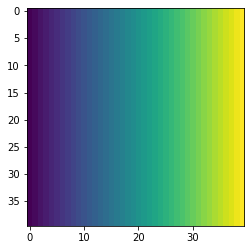

In [13]:
plt.imshow(np.reshape(xdist[0, :],(40,40)))

All these information is saved in a row of the following matrix 

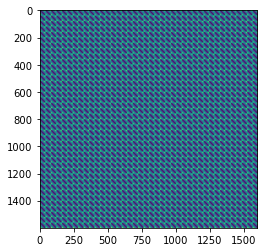

In [14]:
plt.imshow(xdist)#, cmap='gray')

why do I need to compute the distance between each neuron? For the connectivity profile, which enables the creation of grid like pattern.

We can do the same for the y_ distance for one neuron.

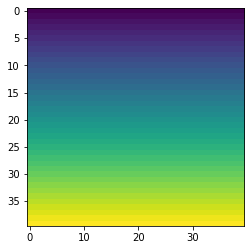

In [21]:
y_ = np.tile(y_c, (n**2,1))
ydist = np.abs(y_-y_.T)
#print(ydist)
fig1= plt.imshow(np.reshape(ydist[0, :],(40,40)))

THe plot below is the stacking of the first row of the following matrix. For all neurons the plot looks as follows.

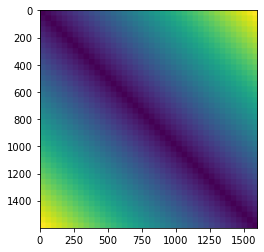

In [24]:
fig2 =plt.imshow(ydist)

If we calculate the eucledian distance the result for the first neuron is:

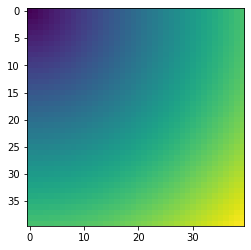

In [27]:
dist = np.sqrt(xdist**2+ydist**2)

plt.imshow(np.reshape(dist[0, :],(40,40)))

So we calculated a distance matrix of neurons to each other with. in addition we connect edges of opposite sides.

In [28]:
#compute distance between 2 coordinates, 
#a and b are 2 vectors of 2 grids (n^2 x 1) coordinates.
def comp_dist(a, b):
    na = int(np.sqrt(len(a)))
    nb = int(np.sqrt(len(b)))
    #print((a))
    a_ = np.tile(a, (nb**2,1))
    b_ = np.tile(b, (na**2,1))
    
    dist1 = np.abs(a_-b_.T)
    dist2 = n - dist1
    return np.minimum(dist1, dist2)

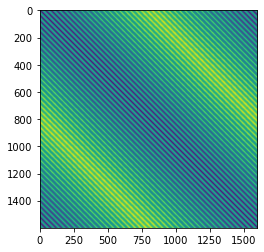

In [31]:
xdist = comp_dist(x_c,x_c)
ydist = comp_dist(y_c,y_c)
dist_f = np.sqrt(xdist**2+ydist**2)
plt.imshow(dist_f)

For the first neuron it looks as follows

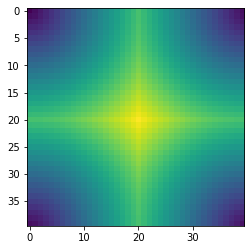

In [35]:
plt.imshow(np.reshape(dist_f[0, :],(40,40)))

Now we define 4 prefered directions of neurons and add directional preference to the neurons. For this we first create an index z that tells which neuron has which preference direction [1, 2, 3, 4]. Then we create a matrix selecting the vectors from the array directions.

In [36]:
directions = [[1,0],[0,1],[-1,0],[0,-1]]#  E N W S
z = 2 * (y_c % 2) + x_c % 2

g = np.take(directions, z, axis=0)# g is an array with the vector of directional preference for each neuron

x_s = x_c - g[:, 0]# subtract to each neuron position the vector of directional preference.
y_s = y_c - g[:, 1]

Now we compute the distance of the each neuron to each other taking into account the shift.

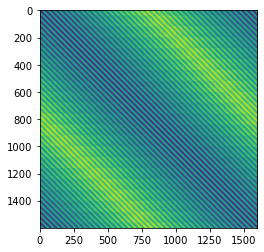

In [37]:
xdist = comp_dist(x_c,x_s)
ydist = comp_dist(y_c,y_s)
dist_f = np.sqrt(xdist**2+ydist**2)
plt.imshow(dist_f)

As we can see there is a shift in the distance metric toward west for the first neuron.

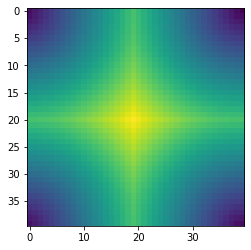

In [39]:
plt.imshow(np.reshape(dist_f[0, :],(40,40)))

Finally we calculate the recurrent weights with rec(d) = e^(−γd^2)− e^(−βd^2)

In [40]:
def rec(d):
    llambda = 15
    beta = 3 /(llambda**2)
    gamma = 1.05*beta
    w = np.exp(-gamma*d**2)-np.exp(-beta*d**2)
    return w

For the first neuron the connectivity profile looks as follows

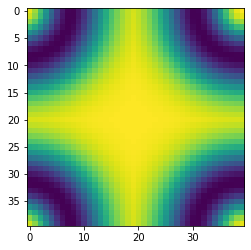

In [42]:
w_rec = rec(dist_f)
plt.imshow(np.reshape(w_rec[0, :], (40,40)))

Now we define the differential equation descibing the system and we solve it

In [43]:
def dynamics(b, s0, w, tau, dt):
    """Solve the grid cell spiking equation with implicit euler for one time step of size dt"""
    
    f = np.maximum(0, np.tensordot(s0, w, axes=1) + b)
    s = (s0 + f * dt / tau) / (1 + dt / tau)
    return s

we define a function B of the input velocity of the agent.

In [44]:
def calculate_B(v):
    g_m = 0.7
    alpha = 0.10315
    tau = 1e-1
    dt = 1e-2
    #print(g)
    #print(v)
    B = 1 + g_m * alpha * np.tensordot(g, v, axes=1)
    return B

Start a simulation, where the differential equation is solved and an initial firing activity forms because the system reaches a stable fixpoint.

In [47]:
nr_steps =300

In [48]:
s = np.random.rand(n**2)*10**(-2)
tau = 1e-1
dt = 1e-2
for i in range(nr_steps):
    v = np.random.rand(2)*0.2
    B = calculate_B(v)
    s = dynamics(B, s, w_rec, tau, dt)
s0 = s

If we plot the activity of each neuron, we can see that  atriangular grid formed.

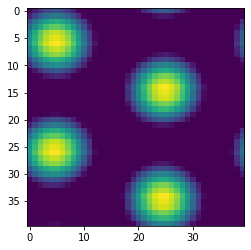

In [49]:
s_resh = np.reshape(s, (40,40))
plt.imshow(s_resh)

If we try to add a velocity vector v= (10,10) for 100 steps. The pattern is shifted.

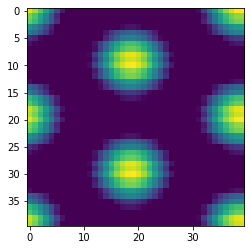

In [51]:
V= np.array([1.5, 1.5])*0.2
nr_steps_shift =1000
fig = plt.figure()
for i in range(nr_steps_shift):
    B = calculate_B(V)
    s = dynamics(B, s, w_rec, tau, dt)

plt.imshow(np.reshape(s, (40,40)))
t = s

# Phase offset detector

Define a decoder phase offset detector. Goal is to get the difference between 2 activation vectors.
- receive a vector s and a vector t ( activity at current and goal location)
- define a grid of phase offset detectors and their preference direction.
- calculate the activation value of the phase offset detector. p_j = f(s*w_in+t*w_out) with defined connectivity profiles.
- calculate the goal vector

Define how the reccurrent connections are defined. 
First a connection w_in from one activity pattern s to the phase offset detector is defined. So from the location x_j of a POD to that of a neuron, annd this for all neurons and all POD.
Therby their distance must be calculated.

In [57]:
def in_(d):
    eta = 0.25
    #print(d.shape)
    beta = 3/ 15**2
    weight_in = eta * ( np.exp(-beta * d**2) - 1 )
    #print(weight_in.shape)
    return weight_in

def ex_(d):
    beta = 3 / 15**2
    weight_ex = np.exp(-beta*d**2)
    return weight_ex


Define the grid of phase offset detectors

In [58]:
n_pod = 10
num_dir = 16
theta_pod = np.linspace(0, 2*np.pi, num_dir+1)
theta_pod = theta_pod[0:num_dir]
#print(theta_pod)
x_pod = np.indices((n_pod,n_pod))*n/n_pod
y_c_pod = np.concatenate(x_pod[0]) 
x_c_pod = np.concatenate(x_pod[1])

Compute distance and connectivity w_in of all phase offset detectors. The plot shows the connectivity profile for the first neuron.

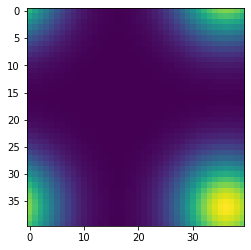

In [60]:
xd = comp_dist(x_c_pod, x_c)
yd = comp_dist(y_c_pod, y_c)
d = np.sqrt(xd**2+yd**2)
w_in = in_(d)
#print(w_in.shape)
plt.imshow(np.reshape(w_in[:,99],(40,40)))

Now we come to the connection of the goal activity to the phase offset detector. First define w_ex for each angle. There are N_pod x N_pod x num_dir phase offset detectors.

In contrast to Tim's code i took 16 angles, such that the last and the first are different. Because 0° and 360° represent the same direction.

The plot shows the reccurrent connectivity profile w_ex of the first neuron of the pphase offset detector to the neural sheet.

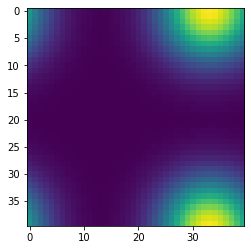

In [64]:
delta = 7 #
w_ex = np.zeros((n**2, n_pod**2, num_dir))
for i, angle in enumerate(theta_pod):
    #print(angle)
    y_c_pod_t = np.concatenate(x[0]) + delta * np.sin(angle)
    x_c_pod_t = np.concatenate(x[1]) + delta * np.cos(angle)
    xd = comp_dist(x_c_pod, x_c_pod_t)
    yd = comp_dist(y_c_pod, y_c_pod_t)
    d = np.sqrt(xd**2+yd**2)
    #print(ex_(d).shape)
    w_ex[:, :, i] = ex_(d)
#print(w_ex[:,:,0].shape)
plt.imshow(np.reshape(w_ex[:,0,0],(40,40)))

Now we have the recurrent correctivity profiles for the phase offset detector. So we calculate the phase offset.  
p_j for each angle has the shape (100) with 16 angle p has the shape (100,16) and it contains the information aboout the response of the phase offset detector along a direction.

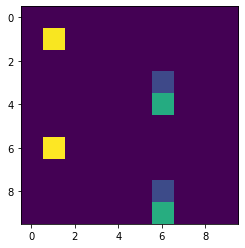

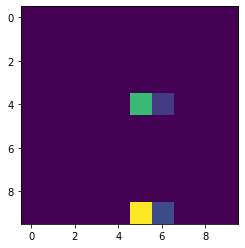

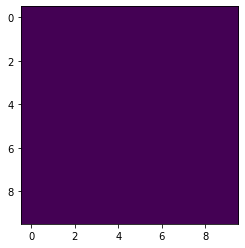

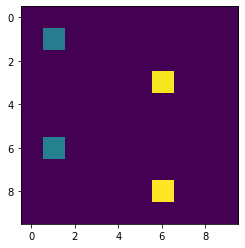

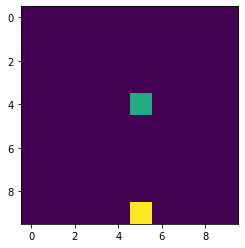

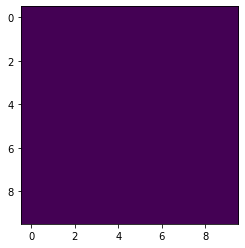

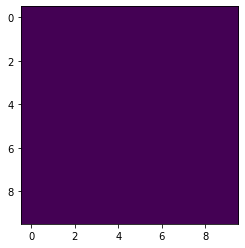

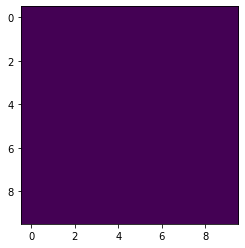

In [67]:
#print(w_ex.shape)

p = np.zeros((n_pod**2, num_dir))
#print(p.shape)
for i, angle in enumerate(theta_pod):
    p[:, i] = np.maximum(0, np.dot(s0, w_in)+ np.dot(t, w_ex[:,:, i]))
    #print(p.shape)
#plt.imshow(np.reshape(p, (10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 2],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 3],(10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 0],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 1],(10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 4],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 5],(10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 6],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 7],(10,10)))

# Motor neurons output
In the next steps the phase offsets in the same directions are aggregated. As there is only one module its just a simple sum.

In [78]:
p_ = np.sum(p, axis = 0)

#  final motor-output signal

Now we add 16 weight vectors with their respective contribution p_.

In [79]:
Theta = np.array([0.0, 0.0])
for i, angle in enumerate(theta_pod):
    Theta += p_[i] * np.array([np.cos(angle), np.sin(angle)])
    
Theta_ = 1/(n_pod**2*num_dir) * Theta

In [80]:
print("The goal vector is", Theta)

The goal vector is [8.66918039 7.392511  ]
